In [1]:
import os
from collections import defaultdict, namedtuple

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

In [2]:
MAT_PATH = "../output/BOSS_DR12_NGC_z1/matrices/"
NSAMP = 2048
NDDIM = 18

In [3]:
Estimation = namedtuple('Estimation', ['mat_type', 'est_type', 'desc'])

In [4]:
H_ref = (NSAMP - NDDIM - 2)/(NSAMP - 1)

S_ref = np.loadtxt(os.path.join(MAT_PATH, "n2048/cov_sample/cov_18_18_sample_2048_v1.matrix"))
Sinv_ref = H_ref * np.linalg.inv(S_ref)

eigmodes = np.arange(NDDIM) + 1
eigvals_ref = np.linalg.eigvalsh(Sinv_ref)


def norm(M):
    return np.sqrt(np.abs(np.trace(M @ M.T)))


def loss(M):
    return norm(linalg.sqrtm(M) @ (S_ref / H_ref) @ linalg.sqrtm(M) - np.eye(NDDIM))

In [5]:
nsamp = 2048
hfact = (nsamp - NDDIM - 2)/(nsamp - 1)

cases = [
    Estimation(*attrs) for attrs in [
        # ('cov', 'sample', "Sample"),
        ('cov', 'shrinkage_Sii', r"Covariance shrinkage, target $\mathbf{T}^{(1)}$ (empirical)"),
        ('cov', 'shrinkage_P', r"Covariance shrinkage, target $\mathbf{T}^{(2)}$ (analytical)"),
        ('cov', 'NERCOME', r"NERCOME"),
        ('pre', 'shrinkage_inv_then_diag', r"Precision shrinkage, target $\mathbf{\Pi}_0^{(1)}$ (empirical)"),
        ('pre', 'shrinkage_diag_then_inv', r"Precision shrinkage, target $\mathbf{\Pi}_0^{(2)}$ (empirical)"),
        ('pre', 'shrinkage_P', r"Precision shrinkage, target $\mathbf{\Pi}_0^{(3)}$ (analytical)"),
    ]
]
linestyles = [
    '-',
    '-',
    ':',
    '-.',
    '-.',
    '-.',
]

eigvals = defaultdict(list)
losses = defaultdict(list)

In [6]:
for caseidx, estimation in enumerate(cases):
    mat_path = os.path.join(MAT_PATH, f"n{nsamp}/{estimation.mat_type}_{estimation.est_type}")
    mat_files = [f for f in os.listdir(mat_path) if not f.startswith('.')]

    for fname in mat_files:
        matrix = np.loadtxt(os.path.join(mat_path, fname))
        if estimation.mat_type == "cov":
            precmat = np.linalg.inv(matrix)
            if estimation.est_type == "sample":
                precmat *= hfact
        elif estimation.mat_type == "pre":
            precmat = matrix
        else:
            raise ValueError(f"Unknown matrix type: {estimation.mat_type}.")

        eigvals[estimation].append(np.linalg.eigvalsh(precmat))
        losses[estimation].append(loss(precmat))

In [7]:
for estimation in losses.keys():
    med = np.median(losses[estimation])
    low = med - np.quantile(losses[estimation], 0.16)
    high = np.quantile(losses[estimation], 0.84) - med
    if nsamp == NSAMP:
        print(f"{estimation.mat_type} {estimation.est_type}: {med:.3f}, {low:.3f}, {high:.3f}")
    else:
        print(f"{estimation.mat_type} {estimation.est_type}: {med:.1f}, {low:.1f}, {high:.1f}")

cov shrinkage_Sii: 0.051, 0.000, 0.000
cov shrinkage_P: 0.048, 0.000, 0.000
cov NERCOME: 0.054, 0.000, 0.000
pre shrinkage_inv_then_diag: 0.075, 0.000, 0.000
pre shrinkage_diag_then_inv: 0.075, 0.000, 0.000
pre shrinkage_P: 0.013, 0.000, 0.000


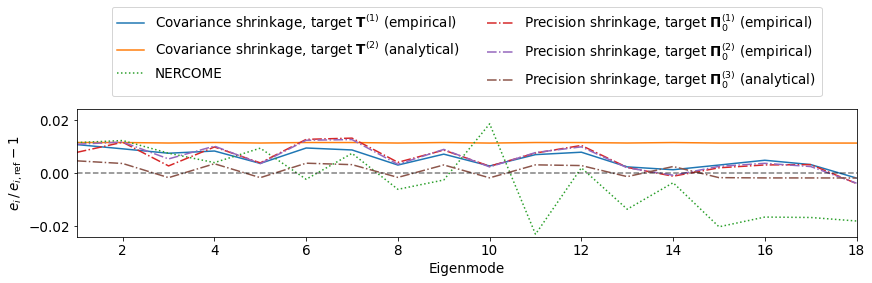

In [10]:
fig, ax = plt.subplots(figsize=(12., 3.5), constrained_layout=True)

for caseidx, (estimation, ls) in enumerate(zip(cases, linestyles)):

    ax.plot(
        eigmodes, eigvals[estimation][0] / eigvals_ref - 1,
        ls=ls,
        label=estimation.desc
    )

ax.axhline(0, ls='--', c='k', alpha=.5)

ax.set_xlim(1., 18.)
ax.set_ylim(-0.024, 0.024)
ax.tick_params(axis='both', which='major', labelsize=13.5)
ax.set_xlabel("Eigenmode", fontsize=13.5)
ax.set_ylabel(r"$e_i \,/\, e_{i,\mathrm{ref}} - 1$", fontsize=13.5)

ax.legend(fontsize=13.5, ncol=2, loc='center', bbox_to_anchor=[0.5, 1.45])

#fig.savefig("../output/BOSS_DR12_NGC_z1/plots/", bbox_inches='tight')